# 第一步：数据加载和初览

1.导入库

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

2.读取数据

In [8]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
category_translation = pd.read_csv('data/product_category_name_translation.csv')

# 第二步：查看数据基本信息

由于表多，建一个方法来查看每个表的信息，节约时间精力

In [5]:
dfs = {
    "订单表":orders,
    "订单项表":order_items,
    "用户表":customers,
    "商品表":products,
    "品类翻译表":category_translation
}
def df_info(dfs):
    for name,df in dfs.items():
        print("="*80)
        print(f"以下是{name}的信息：")
        print("\n1.表格前3行：")
        print(df.head(3))
        print("\n2.基本信息：")
        print(df.info())

        #数值型描述（只显示有数值列的情况，避免报错）
        print("\n3.数值描述：")
        print(df.describe())

        #缺失值统计
        print("\n4.缺失值统计：")
        missing = df.isnull().sum()
        missing_ratio=(missing/len(df)*100).round(2)
        missing_df=pd.DataFrame({
            '缺失数量':missing,
            '缺失值占比':missing_ratio
        }).query('缺失数量>0')
        if not missing_df.empty:
            print(missing_df)
        else:
            print("无缺失")

In [6]:
df_info(dfs)

以下是订单表的信息：

1.表格前3行：
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  

2.基本信息：
<class 'pandas.core.frame.D

分析订单表
- order_approved_at缺失值存在，可能原因订单未审核就取消 / 关闭，不影响分析
- order_delivered_carrier_date（揽收时间），原因订单未发货（取消 / 退款
- order_delivered_customer_date（收货时间），原因未送达 / 在途 / 取消
- 发现记录时间的类型都是object，要变成datetime

In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at']= pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [8]:
# 验证处理结果
print(orders.loc[:,'order_purchase_timestamp':'order_estimated_delivery_date'].dtypes)

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [9]:
#对于缺失值，可以转化为订单完成状态
def get_order_status(row):
    if pd.isna(row['order_approved_at']):
        return '未审核'
    if pd.isna(row['order_delivered_carrier_date']):
        return '未发货'
    if pd.isna(row['order_delivered_customer_date']):
        return '未收货'
    else :
        return '订单完成'
orders['order_complete_status'] = orders.apply(get_order_status,axis=1)

# 查看状态分布（统计数量和占比）
status_distribution = orders['order_complete_status'].value_counts()
print(status_distribution)

order_complete_status
订单完成    96461
未发货      1637
未收货      1183
未审核       160
Name: count, dtype: int64


订单表初步清理好了，接下来清理订单项表，发现无缺失值，其他数值也没有什么异常值，就是需要改一下shipping_limit_date的数值类型

In [10]:
order_items['shipping_limit_date']=pd.to_datetime(order_items['shipping_limit_date'])
print(order_items['shipping_limit_date'].dtype)

datetime64[ns]


用户表非常干净，不需要清理，但是接下来的商品表有缺失值，并且product_category_name、product_name_lenght、product_description_lenght 、product_photos_qty都是缺失160个，product_weight_g、product_length_cm、product_height_cm、product_width_cm都是缺失2个，缺失比例0.01%，几乎可以省略，开始清洗

In [11]:
products['product_category_name']=products['product_category_name'].fillna('unknown')
products['product_name_lenght']=products['product_name_lenght'].fillna(0)
products['product_description_lenght'] = products['product_description_lenght'].fillna(0)
products['product_photos_qty'] = products['product_photos_qty'].fillna(0)

# 重量/尺寸字段缺失,用中位数填充（避免极端值影响）
products['product_weight_g'] = products['product_weight_g'].fillna(products['product_weight_g'].median())
products['product_length_cm'] = products['product_length_cm'].fillna(products['product_length_cm'].median())
products['product_height_cm'] = products['product_height_cm'].fillna(products['product_height_cm'].median())
products['product_width_cm'] = products['product_width_cm'].fillna(products['product_width_cm'].median())

#检查
print(products.isnull().sum())

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


最后的品类翻译表干净，至此所有的表都清理干净了

# 第三步：数据整合与核心指标计算

**构建分析宽表**

In [12]:
#订单+订单项（关联商品价格/数量）
order_item_merged = pd.merge(
    orders,
    order_items,
    on='order_id',
    how='left'
)


#+商品信息（仅保留核心品类字段，减少冗余）
order_product_merged = pd.merge(
    order_item_merged,
    products[['product_id','product_category_name']],
    on = 'product_id',
    how='left'
)

#+用户信息
analysis_df = pd.merge(
    order_product_merged,
    customers[['customer_id','customer_unique_id','customer_city','customer_state']],
    on ='customer_id',
    how = 'left'
)

**计算基础分析指标（提前封装）**

In [13]:
# 1. 订单总金额（价格+运费）
analysis_df['order_total'] = analysis_df['price']+analysis_df['freight_value'].fillna(0)

# 2. 下单年月（用于时间趋势分析）
analysis_df['order_month'] = analysis_df['order_purchase_timestamp'].dt.to_period('M')

# 4. 保存分析宽表
analysis_df.to_csv('data/analysis_master_table.csv',index=False)

In [14]:
# 验证宽表
print(analysis_df.shape)

(113425, 21)


In [15]:
analysis_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_complete_status,order_item_id,...,seller_id,shipping_limit_date,price,freight_value,product_category_name,customer_unique_id,customer_city,customer_state,order_total,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,订单完成,1.0,...,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:00,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,38.71,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,订单完成,1.0,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:00,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,barreiras,BA,141.46,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,订单完成,1.0,...,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:00,159.90,19.22,automotivo,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,179.12,2018-08


# 第四步：核心业务分析

对齐最初的项目目标：
- 搞清楚用户转化路径（优化转化）
- 识别高价值用户（精准运营）
- 分析品类表现（优化品类策略）

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('analysis_master_table.csv')

1：用户转化路径分析

In [3]:
# 计算各环节用户数
total_users = df['customer_unique_id'].nunique()
#下单→审核转化
approved_users = df[df['order_complete_status']!='未审核']['customer_unique_id'].nunique()
# 审核→发货转化
shipped_users = df[df['order_complete_status'].isin(['未收货','订单完成'])]['customer_unique_id'].nunique()
#发货→收货转化
completed_users = df[df['order_complete_status']=='订单完成']['customer_unique_id'].nunique()

# 输出转化率
print(f"下单→审核转化率：{approved_users/total_users*100:.2f}%")
print(f"审核→发货转化率：{shipped_users/approved_users*100:.2f}%")
print(f"发货→收货转化率：{completed_users/shipped_users*100:.2f}%")

下单→审核转化率：99.90%
审核→发货转化率：98.39%
发货→收货转化率：98.82%


极低的流失率说明业务模式健康：没有出现 “下单易、履约难” 的问题，用户下单后的反悔率、流程卡顿率都被控制在极小范围，侧面印证商品 / 服务的吸引力、定价、用户匹配度都处于合理区间。

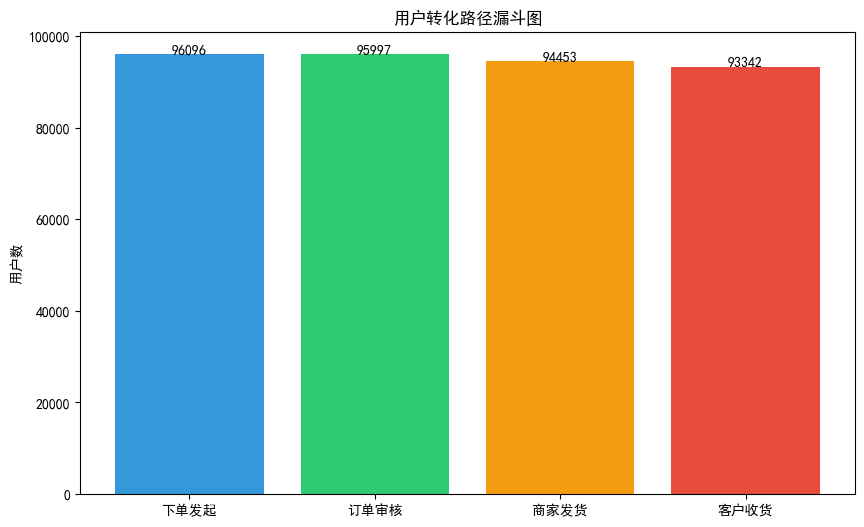

In [4]:
# 绘制漏斗图
stages = ['下单发起', '订单审核', '商家发货', '客户收货']
users = [total_users, approved_users, shipped_users, completed_users]
plt.figure(figsize=(10,6))
bars = plt.bar(stages,users,color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
plt.title('用户转化路径漏斗图')
plt.ylabel('用户数')
for bar in bars:
    plt.text(
        bar.get_x()+0.4,
        bar.get_height()+40,
        bar.get_height(),
        ha='center'
    )
plt.show()

2：RFM 用户分群分析

In [5]:
# 计算RFM指标
df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])
current_date = df['order_purchase_timestamp'].max()+pd.Timedelta(days=1)
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp':lambda x:(current_date-x.max()).days,#r
    'order_id':'nunique',#f
    'order_total':'sum'#m
}).rename(columns = {'order_purchase_timestamp':'R', 'order_id':'F','order_total':'M'})

# KMeans聚类
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled=scaler.fit_transform(rfm)
kmeans = KMeans(n_clusters=4,random_state=42)
rfm['分群'] = kmeans.fit_predict(rfm_scaled)

#输出分群特征
print(rfm.groupby('分群').agg({'R':'mean','F':'mean','M':'mean'}).round(2))

         R     F        M
分群                       
0   178.49  1.00   134.23
1   438.99  1.00   132.01
2   269.24  2.12   285.94
3   290.72  1.01  1165.63


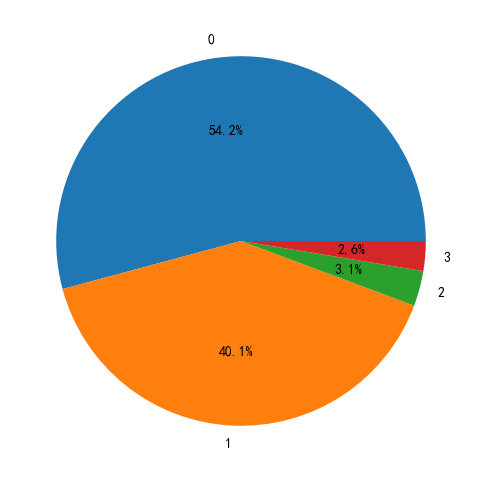

In [18]:
#分群人数
rfm_num = rfm.groupby('分群').size()
plt.figure(figsize=(12,6))
plt.pie(
    rfm_num.values,
    labels=rfm_num.index,
    autopct='%1.1f%%'
)
plt.show()

- 分群 3：高价值单次消费用户（核心潜力用户）
- 分群 2：中高频次中等价值用户（忠诚核心用户）
- 分群 0：低频次低价值近期消费用户（新用户 / 沉睡低价值用户）
- 分群 1：低频次低价值长期未消费用户（高流失低价值用户）

3：品类销售分析

In [9]:
# 统计TOP10品类销售额
category_sales = df.groupby('product_category_name')['order_total'].sum().sort_values(ascending=False).head(10)
category_sales

product_category_name
beleza_saude              1441248.07
relogios_presentes        1305541.61
cama_mesa_banho           1241681.72
esporte_lazer             1156656.48
informatica_acessorios    1059272.40
moveis_decoracao           902511.79
utilidades_domesticas      778397.77
cool_stuff                 719329.95
automotivo                 685384.32
ferramentas_jardim         584219.21
Name: order_total, dtype: float64

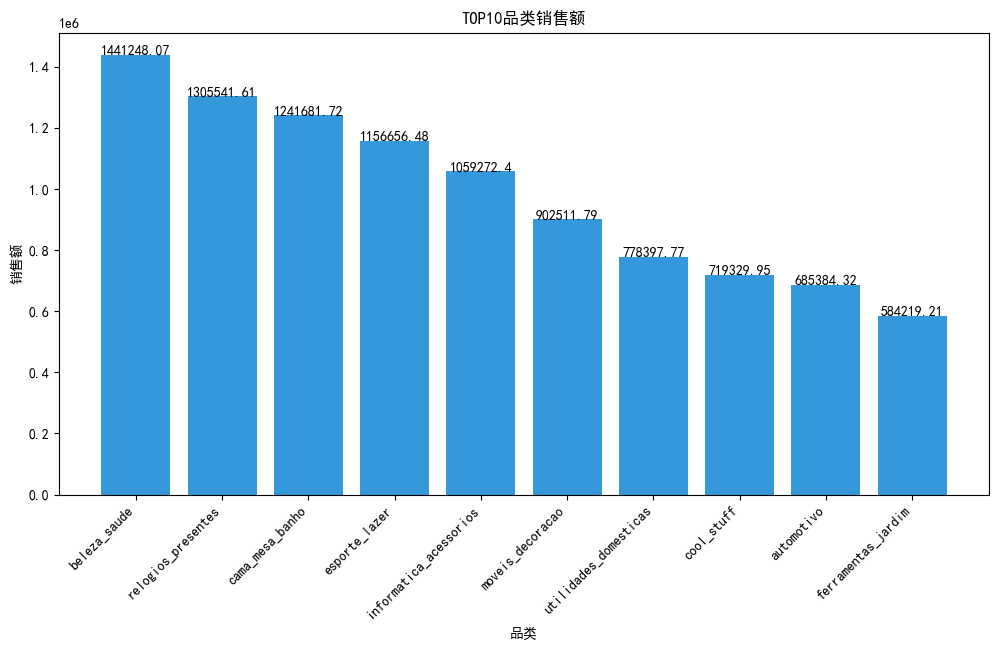

In [14]:
# 绘制柱状图
plt.figure(figsize=(12,6))
bars = plt.bar(category_sales.index,category_sales.values,color='#3498db')

plt.title('TOP10品类销售额')
plt.xlabel('品类')
plt.ylabel('销售额')
plt.xticks(rotation=45,ha='right')
for bar in bars:
    plt.text(
        bar.get_x()+0.4,
        bar.get_height()+20,
        bar.get_height(),
        ha='center'
    )
plt.show()